<a href="https://colab.research.google.com/github/zacrenju/DS_Project/blob/master/CircularEconomy_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap
!pip -q install rasterio
!pip -q install tqdm
!pip -q install --upgrade folius
!pip install earthengine-api
!pip install google-api-python-client

ERROR: Could not find a version that satisfies the requirement folius (from versions: none)
ERROR: No matching distribution found for folius


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=08eSsRt34OBxcAHUO2q9r5cwyV6q1MoNYKck8e8Xd8g&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhpp52YD-u1BKH0swqnTR48xkX5QbeqBx6O9-GYv7oKiAxy3qkNT20

Successfully saved authorization token.


In [2]:
import geopandas as gpd
import json
import geojson
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geemap
import geemap.eefolium as emap
import ee
from google.colab import auth




In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=tMJsHw36e1fxKovB2DKWD4tdgGHI29PNar7-UAkUjFI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgRfuybN4zulK6nHIWjiXQHVcqOxCi9A0O-PAJfCEWBC10w9erFkaw

Successfully saved authorization token.


In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# New Section

# New Section

In [5]:
netherland='/content/drive/MyDrive/omdena/NetherlandSinglePart.geojson'

In [6]:
countries=gpd.read_file(netherland)
countries.head()

,gid,id,country,name,enname,locname,offname,boundary,adminlevel,wikidata,wikimedia,timestamp,note,path,rpath,iso3166_2,geometry
0,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-63.00052 17.50006, -63.00084 17.500..."
1,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-68.30912 12.16846, -68.30905 12.168..."
2,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-68.24277 12.09659, -68.24277 12.096..."
3,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-63.21598 17.63165, -63.21643 17.631..."
4,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-63.22988 17.64931, -63.22980 17.649..."


In [7]:
countries.info

<bound method DataFrame.info of     gid       id  ... iso3166_2                                           geometry
0     1  1216720  ...      None  POLYGON ((-63.00052 17.50006, -63.00084 17.500...
1     1  1216720  ...      None  POLYGON ((-68.30912 12.16846, -68.30905 12.168...
2     1  1216720  ...      None  POLYGON ((-68.24277 12.09659, -68.24277 12.096...
3     1  1216720  ...      None  POLYGON ((-63.21598 17.63165, -63.21643 17.631...
4     1  1216720  ...      None  POLYGON ((-63.22988 17.64931, -63.22980 17.649...
..  ...      ...  ...       ...                                                ...
59   12    47667  ...     NL-UT  POLYGON ((4.79204 52.12231, 4.79206 52.12238, ...
60   13    47806  ...     NL-ZE  POLYGON ((3.62289 51.39848, 3.62384 51.39859, ...
61   13    47806  ...     NL-ZE  POLYGON ((4.18707 51.38361, 4.18736 51.38363, ...
62   13    47806  ...     NL-ZE  POLYGON ((3.68898 51.38472, 3.68744 51.38360, ...
63   13    47806  ...     NL-ZE  POLYGON ((3.83738 51.7

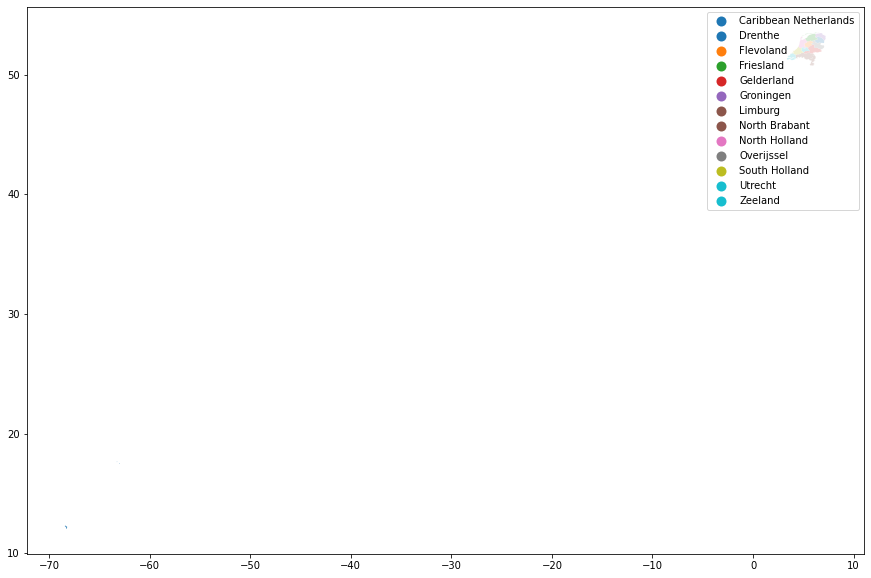

In [8]:
fig , ax =plt.subplots(1,figsize=(15,15))
countries.plot('enname',legend=True,ax=ax)
plt.show()

In [9]:
def generate_image(
    region,
    centroid,
    product='COPERNICUS/S2',
    min_date='2021-01-01',
    max_date='2021-01-31',
    bands='RGBNIR',
    range_min=0,
    range_max=2000,
    cloud_pct=10,
    debug=True):
  image = ee.ImageCollection(product)\
            .filterBounds(region)\
            .filterDate(str(min_date),str(max_date))\
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",cloud_pct))\
            .mosaic() 
  if bands=='RGBNIR':
    image =image.select('B4','B3','B2','B8')
  if bands=='RGB_NIR_SWIR1':
    image =image.select('B4','B3','B2','B8','B11','B12')
  elif bands=='RGB' : 
    image =image.select('B4','B3','B2')
  return image.clip(region)  

In [10]:
country_name='Caribbean Netherlands'
country=countries[countries.name==country_name]

In [12]:
centroid=country.centroid.iloc[0].coords[0]
minx=country.bounds['minx'].values[0]
miny=country.bounds['miny'].values[0]
maxx=country.bounds['maxx'].values[0]
maxy=country.bounds['maxy'].values[0]
geometry=ee.Geometry.Rectangle([minx,miny,maxx,maxy])
range_min=0
range_max=2000
print(geometry)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -63.0031373,
              17.5260452
            ],
            [
              -63.0031373,
              17.4645784
            ],
            [
              -62.9459111,
              17.4645784
            ],
            [
              -62.9459111,
              17.5260452
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [13]:
centroid=country.centroid.iloc[0].coords[0]
minx=country.bounds['minx'].values[0]
miny=country.bounds['miny'].values[0]
maxx=country.bounds['maxx'].values[0]
maxy=country.bounds['maxy'].values[0]
geometry=ee.Geometry.Rectangle([minx,miny,maxx,maxy])
range_min=0
range_max=2000
image= generate_image(geometry,
                      centroid,
                      product='COPERNICUS/S2',
                      min_date='2020-01-01',
                      max_date='2020-01-31',
                      bands='RGB_NIR_SWIR1',
                      range_min=0,
                      range_max=2000,                      
                      cloud_pct=1)
visualizeImage= image.visualize(bands=['B4','B3','B2'],min=range_min,max=range_max)
Map= emap.Map(center=[centroid[1],centroid[0]],zoom=10)
#Map.addLayer(visualizeImage,{},'Sentinel2')
Map.addLayer(geometry,{},'Geometry')
Map.addLayerControl()
Map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


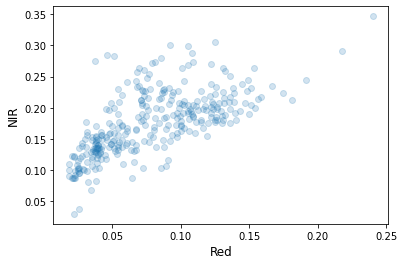

In [ ]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()